<a href="https://colab.research.google.com/github/Altemir1/Crypto-DL-Based-Trading-System/blob/main/LSTM_price_predicton_with_technical_indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import pandas as pd

df = pd.read_csv("eth_ti_1d.csv")

df.head()

,date,date.1,open,high,low,close,volume,volume_usd,ema_5,ema_20,...,kc_lower,donchian_upper,donchian_lower,donchian_middle,obv,vwap_num,vwap_denom,vwap,cmf,ad_line
0,2017-10-05,2017-10-05,290.00,297.44,285.53,294.81,3412.39016,1.006007e+06,295.022651,292.872474,...,263.742167,313.0,235.51,274.255,-25872.70630,8.192443e+07,272334.71430,300.822589,0.105217,25469.769973
1,2017-10-06,2017-10-06,294.78,310.80,293.78,310.80,3541.02359,1.100550e+06,300.281767,294.579858,...,267.352000,313.0,239.02,276.010,-22331.68271,8.302498e+07,275875.73789,300.950654,0.183252,29010.793563
2,2017-10-07,2017-10-07,309.90,318.50,303.60,311.01,2165.79076,6.735826e+05,303.857845,296.144633,...,270.744667,318.5,252.10,285.300,-20165.89195,8.369857e+07,278041.52865,301.029011,0.163131,28999.165156
3,2017-10-08,2017-10-08,311.08,317.07,309.00,311.07,2960.93198,9.210571e+05,306.261897,297.566097,...,274.117333,318.5,252.10,285.300,-17204.95997,8.461962e+07,281002.46063,301.134813,0.121816,27557.224304
4,2017-10-09,2017-10-09,311.13,312.13,286.65,297.19,4885.37863,1.451886e+06,303.237931,297.530278,...,274.548833,318.5,252.10,285.300,-22090.33860,8.607151e+07,285887.83926,301.067403,0.116781,26713.595341


In [111]:
df.drop(columns=["date.1", ], inplace=True)

Select necessary features

In [112]:
df_selected = df.drop(columns=["open",
                               "high",
                               "low",
                               "volume",
                               "vwap_num",
                               "vwap_denom",
                               "signal",
                               "%K",
                               "bb_middle",
                               "atr",
                               "kc_upper",
                               "kc_middle",
                               "kc_lower",
                               "vwap"])


### Transformations before fitting

In [114]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_price_data(df):
    df = df.copy()

    # Log-transform volume and price
    df['log_volume'] = np.log1p(df['volume_usd'])
    df['log_close'] = np.log1p(df['close'])
    df.drop(columns=['volume_usd', 'close'], inplace=True)

    # Normalize continuous unbounded features
    features_to_normalize = [
        'ema_5', 'ema_20', 'ema_50',
        'macd', 'histogram',
        'adx', 'plus_di', 'minus_di',
        'psar', 'psar_up', 'psar_down',
        'momentum', 'cci',
        'bb_upper', 'bb_lower',
        'donchian_upper', 'donchian_lower', 'donchian_middle',
        'obv', 'ad_line', 'cmf'
    ]


    scaler = MinMaxScaler()
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

    return df


df_selected = preprocess_price_data(df_selected)

# Make a classification task instead of regression for 1 day shift
df_selected['future_return'] = df_selected['log_close'].shift(-1) - df_selected['log_close']
df_selected['target'] = (df_selected['future_return'] > 0).astype(int)  # 1 = price up, 0 = price down
df_selected.drop("future_return", axis=1, inplace=True)
# Add time based features
df_selected["date"] = pd.to_datetime(df_selected["date"])
df_selected['day_of_week'] = df_selected['date'].dt.dayofweek
df_selected['month'] = df_selected['date'].dt.month
df_selected.drop("date", axis=1, inplace=True)


df_selected.head()


,ema_5,ema_20,ema_50,macd,histogram,adx,plus_di,minus_di,psar,psar_down,...,donchian_lower,donchian_middle,obv,cmf,ad_line,log_volume,log_close,target,day_of_week,month
0,0.045622,0.043768,0.043292,0.414870,0.692676,0.426636,0.222829,0.517111,0.032932,0.044638,...,0.038607,0.039937,0.124974,0.575642,0.000172,13.821500,5.689717,1,3,10
1,0.046768,0.044157,0.043416,0.416650,0.694717,0.407605,0.293154,0.488590,0.033547,0.044638,...,0.039488,0.040339,0.125021,0.676949,0.000199,13.911322,5.742362,1,4,10
2,0.047548,0.044514,0.043538,0.418047,0.695637,0.381432,0.326691,0.464236,0.034138,0.044638,...,0.042773,0.042467,0.125050,0.650827,0.000199,13.420367,5.743035,1,5,10
3,0.048072,0.044838,0.043654,0.419114,0.695757,0.357129,0.315849,0.451033,0.035057,0.044638,...,0.042773,0.042467,0.125089,0.597191,0.000188,13.733278,5.743228,0,6,10
4,0.047413,0.044829,0.043634,0.418481,0.692686,0.352575,0.282859,0.558180,0.035921,0.044638,...,0.042773,0.042467,0.125024,0.590654,0.000182,14.188374,5.697731,1,0,10


In [116]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2681 entries, 0 to 2680
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ema_5            2681 non-null   float64
 1   ema_20           2681 non-null   float64
 2   ema_50           2681 non-null   float64
 3   macd             2681 non-null   float64
 4   histogram        2681 non-null   float64
 5   adx              2681 non-null   float64
 6   plus_di          2681 non-null   float64
 7   minus_di         2681 non-null   float64
 8   psar             2681 non-null   float64
 9   psar_down        2681 non-null   float64
 10  psar_up          2681 non-null   float64
 11  rsi              2681 non-null   float64
 12  %D               2681 non-null   float64
 13  cci              2681 non-null   float64
 14  momentum         2681 non-null   float64
 15  bb_upper         2681 non-null   float64
 16  bb_lower         2681 non-null   float64
 17  donchian_upper

### Splitting dataset

In [127]:
target_column = 'target'  # Our prediction target
feature_columns = [col for col in df_selected.columns if col != target_column]

X_raw = df_selected[feature_columns].values  # Features (OHLC, indicators, volume, etc.)
y_raw = df_selected[target_column].values  # Target (log close price)

In [128]:
X_raw.shape

(2681, 27)

Creating sequence of features according to the windwo size

In [129]:
import numpy as np

def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - 1):
        X_seq.append(X[i:i+window_size])  # Select past `window_size` observations
        y_seq.append(y[i+window_size])  # Target is the next Close price
    return np.array(X_seq), np.array(y_seq)

### Model creation and training loop

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,           # Stop if no improvement for 15 epochs
    restore_best_weights=True  # Revert to the best model
)

def build_lstm_model(window_size, num_features):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(window_size, num_features)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation="sigmoid")  # Predicting direction
    ])

    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
    return model

In [130]:
# Define different window sizes
window_sizes = [10, 20, 30, 40, 50, 60, 70]

# Store results
models = {}
history_results = {}
x_tests = {}
y_tests = {}


for window_size in window_sizes:
    print(f"Training LSTM with window size: {window_size}")

    # Create sequences for the current window size
    X, y = create_sequences(X_raw, y_raw, window_size)


    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]


    x_tests[window_size] = X_test
    y_tests[window_size] = y_test

    # Build and train model with automatic validation split
    model = build_lstm_model(window_size, X.shape[2])
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=64,
                        validation_split=0.1,
                        callbacks=[early_stop])  # 10% of training data used as validation

    # Store trained model and history
    models[window_size] = model
    history_results[window_size] = history

Training LSTM with window size: 10
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4931 - loss: 0.6962 - val_accuracy: 0.4579 - val_loss: 0.6968
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5180 - loss: 0.6926 - val_accuracy: 0.4860 - val_loss: 0.6937
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5092 - loss: 0.6936 - val_accuracy: 0.4579 - val_loss: 0.6949
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5097 - loss: 0.6931 - val_accuracy: 0.4579 - val_loss: 0.7047
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5076 - loss: 0.6937 - val_accuracy: 0.4579 - val_loss: 0.6958
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5239 - loss: 0.6919 - val_accuracy: 0.4533 - val_loss: 0.6937
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5178 - loss: 0.6930 - val_accuracy: 0.5421 - val_loss: 0.6927
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4892 - loss: 0.6944 - val_accuracy: 0.4346 - val_loss: 0.

### Evaluation

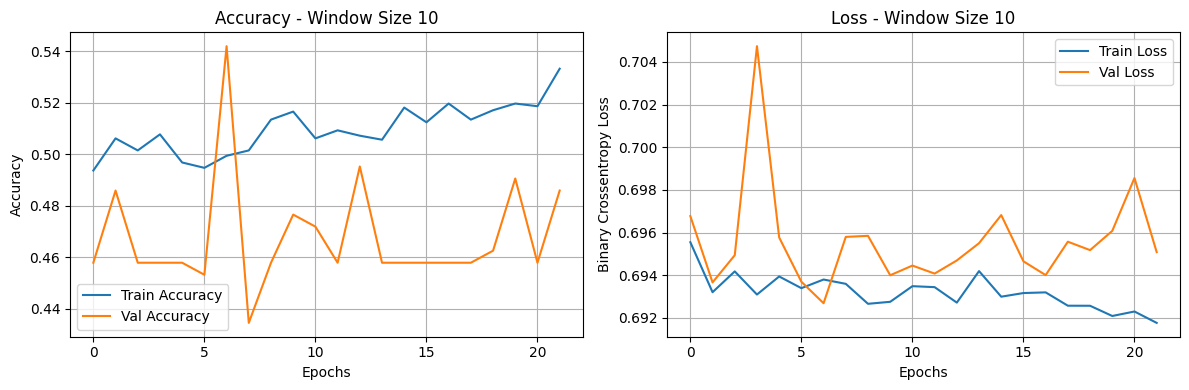

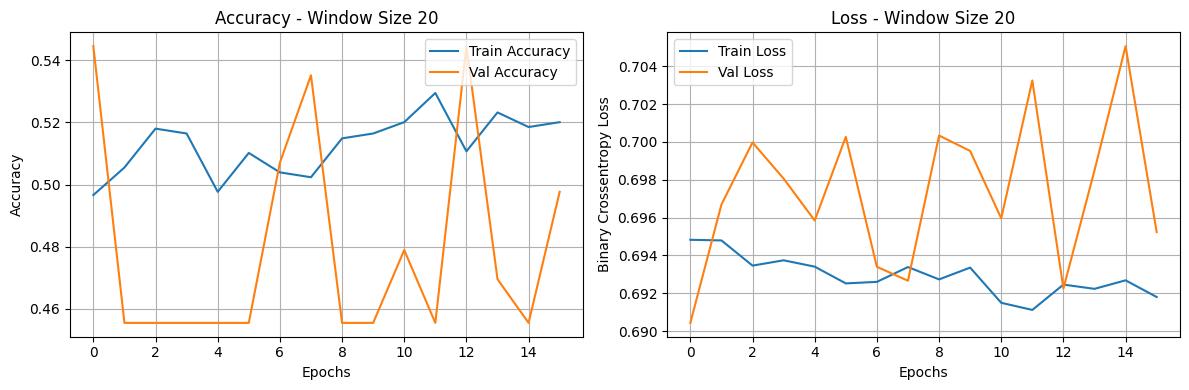

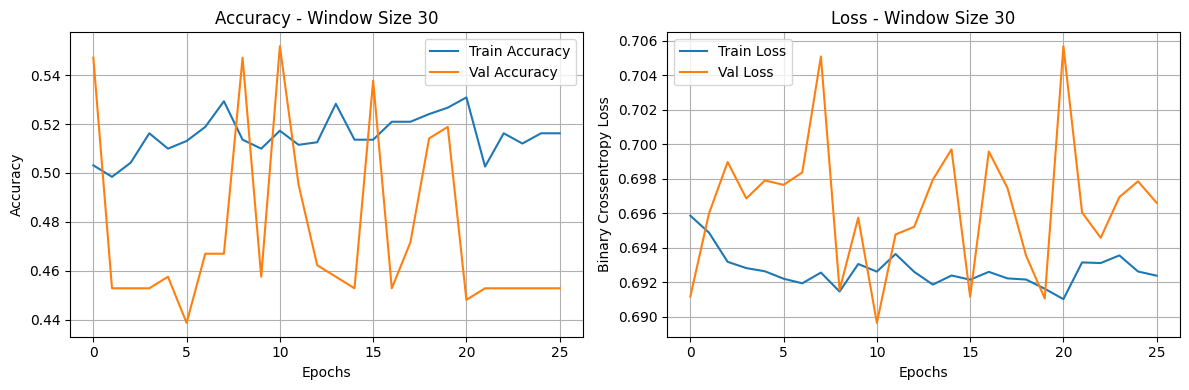

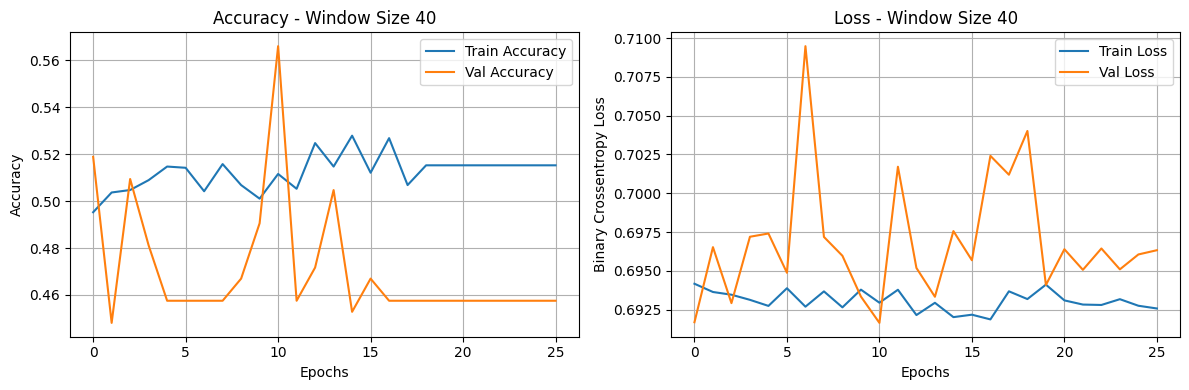

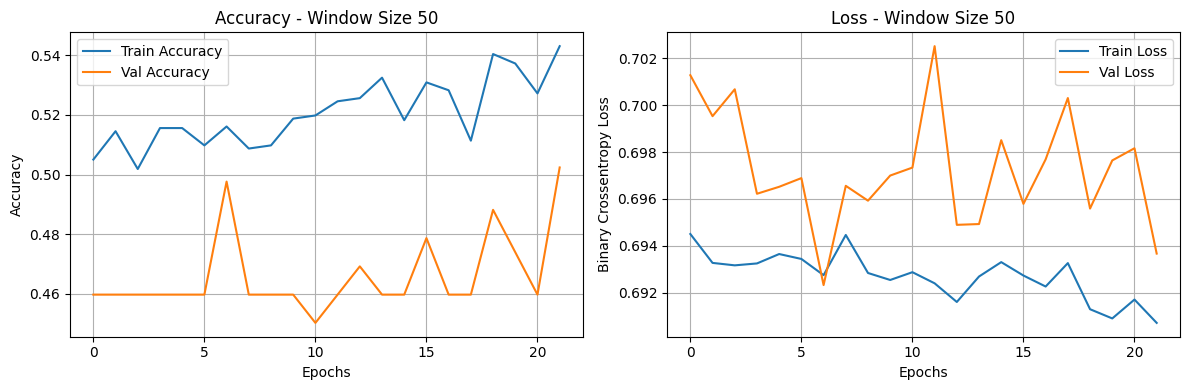

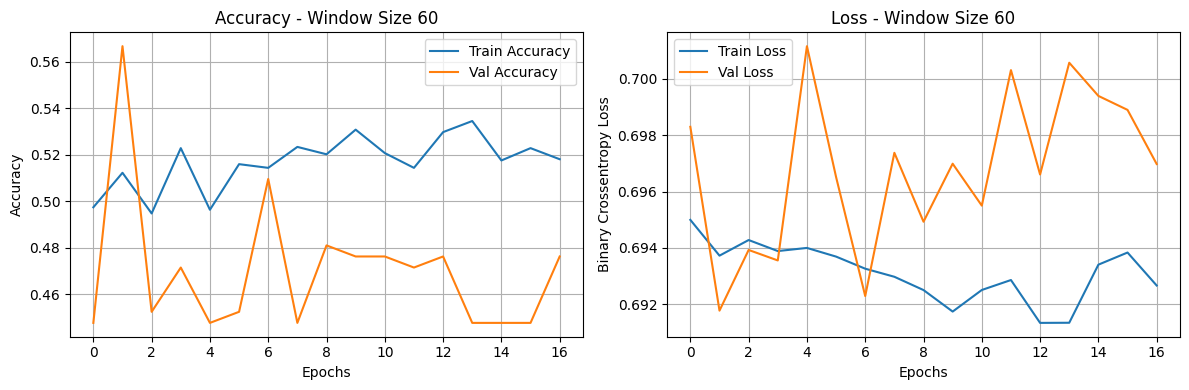

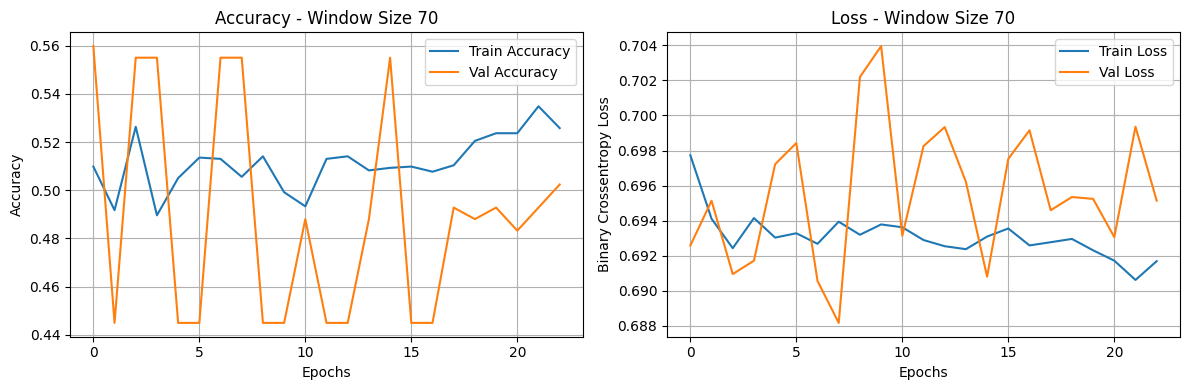

In [131]:
import matplotlib.pyplot as plt

# Loop through results
for window_size in history_results:
    history = history_results[window_size]

    # Plot Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy - Window Size {window_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Window Size {window_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



### Permuation importance

In [132]:
# Create feature name list without target
feature_names = df_selected.columns
feature_names = list(feature_names)
feature_names.remove("target")

print("X_test shape:", X_test.shape)  # Should be (samples, time_steps, num_features)
print("Number of feature names:", len(feature_names))

X_test shape: (522, 70, 27)
Number of feature names: 27


In [133]:
for window_size in history_results:
    X_test = x_tests[window_size]
    y_test = y_tests[window_size]

    print(len(X_test), len(y_test))
    print(X_test.shape, y_test.shape)

534 534
(534, 10, 27) (534,)
532 532
(532, 20, 27) (532,)
530 530
(530, 30, 27) (530,)
528 528
(528, 40, 27) (528,)
526 526
(526, 50, 27) (526,)
524 524
(524, 60, 27) (524,)
522 522
(522, 70, 27) (522,)


In [134]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

for window_size in history_results:
    model = models[window_size]
    X_test = x_tests[window_size]
    y_test = y_tests[window_size]
    # Get baseline accuracy
    y_pred_base = (model.predict(X_test) > 0.5).astype(int)
    baseline_acc = accuracy_score(y_test, y_pred_base)

    # Initialize list to store drops in performance
    importances = []

    # Loop through each feature
    for i in range(X_test.shape[2]):
        X_temp = X_test.copy()

        # Shuffle this specific feature across all samples
        np.random.shuffle(X_temp[:, :, i])

        # Predict again with the shuffled data
        y_pred = (model.predict(X_temp) > 0.5).astype(int)

        # Measure new accuracy
        shuffled_acc = accuracy_score(y_test, y_pred)

        # Importance is how much the accuracy dropped
        drop = baseline_acc - shuffled_acc
        importances.append(drop)

    for i, importance in enumerate(importances):
        print(f"Feature {feature_names[i]}: Importance = {importance}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
